In [1]:
import glob,sys,os,re
import numpy as np
import pandas as pd
from mylab.Functions import *
from core.context_exposure import *
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2

In [2]:
celltypes = index_celltypes()
celltypes = [i for i in celltypes if "aim_test"  in i or "aim_train" in i ]
celltypes = [i for i in celltypes if "20103" not in i]
# celltypes_2020061 = [i for i in celltypes if "20200805" in i or "20200806" in i or "20200807" in i];
celltypes

['\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200810_aim_test.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200811_aim_train.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200812_aim_train.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200814_aim_train.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200816_aim_test.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200818_aim_test.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200819_aim_test.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day20200820_aim_test.pkl',
 '\\\\10.10.47.163\\Data_archive\\qiushou\\results\\celltypes\\celltype_2020061_part5_day2020

In [39]:
# mouseids = ["206550","206551","206552","206553"]
mouseids = ["2020061","206534","206548","206550","206551","206552","206553"]

## index celltype files and categorize
### according to aim,Total_Accuracy,Trial_Num

#### Celltypes continuous

In [40]:
def func(celltypefile):
    stat_info = load_pkl(celltypefile)["stat_info"]
    return stat_info["Total_Accuracy"],stat_info["aim"],stat_info['Trial_Num']



Celltypes = {}
for mouseid in mouseids:
    celltypefiles = [i for i in celltypes if mouseid in i]
    Celltypes[mouseid]={}
    Celltypes[mouseid]["train"]=[]
    Celltypes[mouseid]["40"]=[]
    Celltypes[mouseid]["60"]=[]
    Celltypes[mouseid]["50-60"]=[]
    Celltypes[mouseid]["60-70"]=[]
    Celltypes[mouseid]["70-80"]=[]
    Celltypes[mouseid]["80"] = []
    for celltypefile in celltypefiles:
        TA,aim,TN = func(celltypefile)
        if TN>30:        
            if aim=="test":            
                if TA>=0.4 and TA<0.6:
                    Celltypes[mouseid]["60"].append(celltypefile)
                elif TA <0.4:
                    Celltypes[mouseid]["40"].append(celltypefile)
                elif TA<0.7 and TA>=0.6:
                    Celltypes[mouseid]["60-70"].append(celltypefile)
                elif TA<0.8 and TA>=0.7:
                    Celltypes[mouseid]["70-80"].append(celltypefile)
                else:
                    Celltypes[mouseid]["80"].append(celltypefile)
            else:
                Celltypes[mouseid]["train"].append(celltypefile)

#### Celltypes_discrete

In [396]:
Celltypes_discrete = {}
for mouseid in mouseids:
    celltypefiles = [i for i in celltypes if mouseid in i]
    Celltypes_discrete[mouseid]={}
    Celltypes_discrete[mouseid]["Training"]=[]
    Celltypes_discrete[mouseid]["WellTrain"]=[]
    Celltypes_discrete[mouseid]["others"]=[]
    for celltypefile in celltypefiles:
        TA,aim,TN = func(celltypefile)
        if TN>30:                    
            if TA>=0.4 and TA<0.6:
                Celltypes_discrete[mouseid]["Training"].append(celltypefile)
            elif TA>=0.6:
                Celltypes_discrete[mouseid]["WellTrain"].append(celltypefile)
            else:
                Celltypes_discrete[mouseid]["others"].append(celltypefile)


## calculate the mean cell prop.
### for each mice, there are fixed several stage
if some mice have no data in some stage, we use np.nan
if in one stage, one mouse get several sessions, we get the average

#### Celltypes_prop continuous

In [41]:
Celltypes_prop = {}
for mouseid in Celltypes.keys():
    Celltypes_prop[mouseid]={}
    for stage in Celltypes[mouseid].keys():
        print(stage)
        Celltypes_prop[mouseid][stage]=[]
        if len(Celltypes[mouseid][stage])>0:
            celltype_files = Celltypes[mouseid][stage]
            wenn_lists=[]
            for celltype_file in celltype_files:
                contextcell_ids=[]
                rdcell_ids=[]
                pccell_ids=[]
                
                contextcell_id, rdcell_id,pccell_id,total_cell_num = specific_ids(celltype_file,contexts=[0,1])
                
                contextcell_ids=contextcell_ids+contextcell_id["ctx0cells"]+contextcell_id["ctx1cells"]
                rdcell_ids = rdcell_ids + rdcell_id["context0_leftcells"]+ rdcell_id["context0_rightcells"]+ rdcell_id["context1_leftcells"]+ rdcell_id["context1_rightcells"]
                pccell_ids = pccell_ids + pccell_id["context0_pccells"] + pccell_id["context1_pccells"]
                
                ctx_cellids = list(set(spread(contextcell_ids)))
                rd_cellids = list(set(spread(rdcell_ids)))
                ctx_rd_cellids = [i for i in ctx_cellids if i in rd_cellids]                
                pc_cellids = list(set(spread(pccell_ids)))                
                ctx_pc_cellids = [i for i in ctx_cellids if i in pc_cellids]
                rd_pc_cellids = [i for i in rd_cellids if i in pc_cellids]
                ctx_rd_pc_cellids = [i for i in ctx_rd_cellids if i in pc_cellids]
                wenn_list = [len(ctx_cellids)/total_cell_num
                             ,len(rd_cellids)/total_cell_num
                             ,len(ctx_rd_cellids)/total_cell_num
                             ,len(pc_cellids)/total_cell_num
                             ,len(ctx_pc_cellids)/total_cell_num
                             ,len(rd_pc_cellids)/total_cell_num
                             ,len(ctx_rd_pc_cellids)/total_cell_num]
                wenn_lists.append(wenn_list)
#             print(np.mean(wenn_lists,axis=0))
            Celltypes_prop[mouseid][stage].append([i for i in np.mean(wenn_lists,axis=0)])
        else:
            Celltypes_prop[mouseid][stage].append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

train
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
40
rdcells: try body_speed> 3cm/s
60
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
50-60
60-70
70-80
80
train
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
40
60
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
50-60
60-70
70-80
80
train
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
40
60
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed

#### Celltypes_prop_discrete

In [406]:
Celltypes_prop_discrete = {}
for mouseid in Celltypes_discrete.keys():
    Celltypes_prop_discrete[mouseid]={}
    for stage in Celltypes_discrete[mouseid].keys():
        print(stage)
        Celltypes_prop_discrete[mouseid][stage]=[]
        if len(Celltypes_discrete[mouseid][stage])>0:
            celltype_files = Celltypes_discrete[mouseid][stage]
            wenn_lists=[]
            for celltype_file in celltype_files:
                contextcell_ids=[]
                rdcell_ids=[]
                pccell_ids=[]
                
                contextcell_id, rdcell_id,pccell_id,total_cell_num = specific_ids(celltype_file,contexts=[0,1])
                
                contextcell_ids=contextcell_ids+contextcell_id["ctx0cells"]+contextcell_id["ctx1cells"]
                rdcell_ids = rdcell_ids + rdcell_id["context0_leftcells"]+ rdcell_id["context0_rightcells"]+ rdcell_id["context1_leftcells"]+ rdcell_id["context1_rightcells"]
                pccell_ids = pccell_ids + pccell_id["context0_pccells"] + pccell_id["context1_pccells"]
                
                ctx_cellids = list(set(spread(contextcell_ids)))
                rd_cellids = list(set(spread(rdcell_ids)))
                ctx_rd_cellids = [i for i in ctx_cellids if i in rd_cellids]                
                pc_cellids = list(set(spread(pccell_ids)))                
                ctx_pc_cellids = [i for i in ctx_cellids if i in pc_cellids]
                rd_pc_cellids = [i for i in rd_cellids if i in pc_cellids]
                ctx_rd_pc_cellids = [i for i in ctx_rd_cellids if i in pc_cellids]
                wenn_list = [len(ctx_cellids)/total_cell_num
                             ,len(rd_cellids)/total_cell_num
                             ,len(ctx_rd_cellids)/total_cell_num
                             ,len(pc_cellids)/total_cell_num
                             ,len(ctx_pc_cellids)/total_cell_num
                             ,len(rd_pc_cellids)/total_cell_num
                             ,len(ctx_rd_pc_cellids)/total_cell_num]
                wenn_lists.append(wenn_list)
#             print(np.mean(wenn_lists,axis=0))
            Celltypes_prop_discrete[mouseid][stage].append([i for i in np.mean(wenn_lists,axis=0)])
        else:
            Celltypes_prop_discrete[mouseid][stage].append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

Training
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
WellTrain
rdcells: try body_speed> 3cm/s
others
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
Training
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
WellTrain
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
others
rdcells: try body_speed> 3cm/s
Training
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: try body_speed> 3cm/s
rdcells: 

### organize matrix: stages x celltypes.
here 7 stages and 7 celltypes

#### organized as discrete

In [407]:
Celltypes_prop_discrete

{'206550': {'Training': [[0.49583777400120976,
    0.5114529225195469,
    0.31348234774510086,
    0.34031198292223147,
    0.17078888664855196,
    0.15881428566856454,
    0.10035589352638637]],
  'WellTrain': [[0.4892703862660944,
    0.6394849785407726,
    0.33047210300429186,
    0.2918454935622318,
    0.13304721030042918,
    0.18454935622317598,
    0.0944206008583691]],
  'others': [[0.37221918176493746,
    0.5060489097560273,
    0.23729008842929977,
    0.34562798244856024,
    0.14002746013000356,
    0.17579283924302214,
    0.09086326583518162]]},
 '206551': {'Training': [[0.26354679802955666,
    0.28981937602627256,
    0.09441707717569786,
    0.1691297208538588,
    0.0361247947454844,
    0.03940886699507389,
    0.009852216748768473]],
  'WellTrain': [[0.5181665264928512,
    0.527616244142737,
    0.3159858224198005,
    0.33055388681965636,
    0.17062958068004325,
    0.1731827466057912,
    0.10348432055749128]],
  'others': [[0.5541871921182266,
    0.401477

In [409]:
Stages_discrete_prop={}
for stage in ["Training"]:
    Stages_discrete_prop["Training"]=[]
    for mouseid in mouseids:
        Stages_discrete_prop["Training"].append(Celltypes_prop_discrete[mouseid][stage][0])
for stage in ["WellTrain"]:
    Stages_discrete_prop["WellTrain"]=[]
    for mouseid in mouseids:
        Stages_discrete_prop["WellTrain"].append(Celltypes_prop_discrete[mouseid][stage][0])

In [410]:
aves = []
stds = []
sems=[]
for stage in Stages_discrete_prop.keys():
    ave = [i for i in np.nanmean(Stages_discrete_prop[stage],axis=0)]
    std = [i for i in np.nanstd(Stages_discrete_prop[stage],axis=0,ddof=1)]
    n = len(np.array(Stages_discrete_prop[stage])[:,0]) - np.isnan(Stages_discrete_prop[stage])[:,0].sum()
    sem = std/np.sqrt(n)
#     venn3(ave)
    aves.append(ave)
    stds.append(std)
    sems.append(sem)
#     plt.show()
aves = np.array(aves)
stds = np.array(stds)
sems = np.array(sems)

In [411]:
Stages_discrete_prop_arrs = []
for stage in Stages_discrete_prop.keys():
    Stages_discrete_prop_arrs.append(Stages_discrete_prop[stage])
Stages_discrete_prop_arrs = np.array(Stages_discrete_prop_arrs)
np.shape(Stages_discrete_prop_arrs) # stage mouse types

(2, 3, 7)

In [412]:
from mylab.ana.Mstat import *

In [413]:
for i in range(7): # 7 celltypes
    print("--------------------------")
    cell_types = Stages_discrete_prop_arrs[:,:,i]    
    print(Wilcoxon_ranksumstest(cell_types[0,:],cell_types[1,:])[1])

--------------------------
0.27523352407483426
--------------------------
0.12663045794761718
--------------------------
0.27523352407483426
--------------------------
0.27523352407483426
--------------------------
0.27523352407483426
--------------------------
0.27523352407483426
--------------------------
0.27523352407483426


In [54]:
cell_types[0,:]

array([0.04467408, 0.05325444, 0.02291789, 0.03613023, 0.03817734,
       0.02665197, 0.06655711])

Text(0.5, 1.05, 'Part5-Cell proporotion along performance')

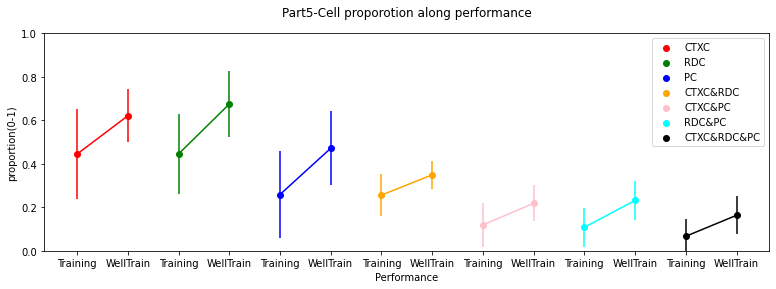

In [414]:
colors = ["red","green","blue","orange","pink","cyan","black"]
plt.figure(figsize=(13,4))
handles=[]
for i in range(7): # different celltypes
    x = np.array([1,2])+2*i
    y = aves[:,i]
#     sns.regplot(x,y,color=colors[i])
    y_err = stds[:,i]
    h=plt.scatter(x,y,color=colors[i])    
    plt.errorbar(x,y,yerr=y_err,color=colors[i],linestyle="-")
    handles.append(h)
#     if i == 3:
#         plt.plot(x,aves[2:,0]*aves[2:,1],"--",color=colors[i])
#     if i == 4:
#         plt.plot(x,aves[2:,0]*aves[2:,2],"--",color=colors[i])
#     if i == 5:
#         plt.plot(x,aves[2:,1]*aves[2:,2],"--",color=colors[i])
#     if i == 6:
#         plt.plot(x,aves[2:,0]*aves[2:,1]*aves[2:,2],"--",color=colors[i])
plt.legend(handles=handles,labels=["CTXC","RDC","PC","CTXC&RDC","CTXC&PC","RDC&PC","CTXC&RDC&PC"])
plt.xticks(ticks=np.arange(1,15),labels=['Training', 'WellTrain']*7,rotation=0)
plt.xlabel("Performance")
plt.ylabel("proportion(0-1)")
plt.ylim(0,1)
plt.title("Part5-Cell proporotion along performance",y=1.05)

#### organized as continuous performance

In [42]:
Stages_prop={}
stages = ['train', '40', '60', '60-70', '70-80', '80']
for stage in stages:
    Stages_prop[stage]=[]
    for mouseid in  mouseids:
        Stages_prop[stage].append(Celltypes_prop[mouseid][stage][0])

aves = []
stds = []
sems = []
for stage in Stages_prop.keys():
    ave = [i for i in np.nanmean(Stages_prop[stage],axis=0)]
    std = [i for i in np.nanstd(Stages_prop[stage],axis=0,ddof=1)]
    n = len(np.array(Stages_prop[stage])[:,0]) - np.isnan(Stages_prop[stage])[:,0].sum()
    sem = std/np.sqrt(n)
#     venn3(ave)
    aves.append(ave)
    stds.append(std)
    sems.append(sem)
#     plt.show()
aves = np.array(aves)
stds = np.array(stds)
sems = np.array(sems)

In [43]:
Stages_prop_arrs = []
for stage in stages:
    Stages_prop_arrs.append(Stages_prop[stage])

Stages_prop_arrs = np.array(Stages_prop_arrs) # stages mice celltypes

In [45]:
np.shape(Stages_prop_arrs)

(6, 7, 7)

Text(0.5, 1.05, 'Part5-Cell proporotion along performance')

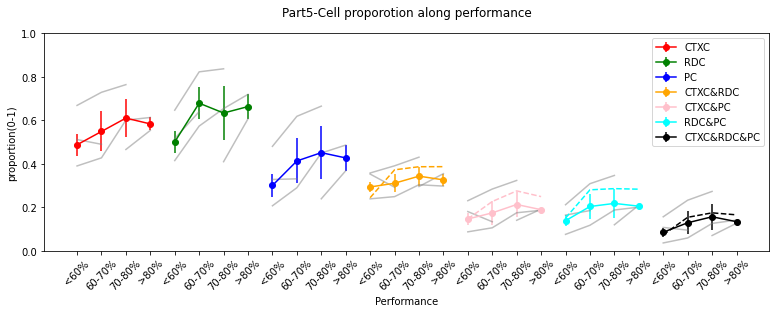

In [46]:
colors = ["red","green","blue","orange","pink","cyan","black"]
plt.figure(figsize=(13,4))
handles=[]
for i in range(7): # different celltypes
    x = np.array([1,2,3,4])+4*i
    y = aves[2:,i]
    scatters = Stages_prop_arrs[1:,:,i]
#     sns.regplot(x,y,color=colors[i])
    y_err = sems[2:,i]
#     h=plt.scatter(x,y,color=colors[i])  
    

    for n in range(7): # four mice
        ys =scatters[1:,n]
        plt.plot(x,ys,color="gray",alpha=0.5)
        
    h=plt.errorbar(x,y,yerr=y_err,color=colors[i],linestyle="-",marker="o")
    handles.append(h)
    if i == 3:
        plt.plot(x,aves[2:,0]*aves[2:,1],"--",color=colors[i])
    if i == 4:
        plt.plot(x,aves[2:,0]*aves[2:,2],"--",color=colors[i])
    if i == 5:
        plt.plot(x,aves[2:,1]*aves[2:,2],"--",color=colors[i])
    if i == 6:
        plt.plot(x,aves[2:,0]*aves[2:,1]*aves[2:,2],"--",color=colors[i])
plt.legend(handles=handles,labels=["CTXC","RDC","PC","CTXC&RDC","CTXC&PC","RDC&PC","CTXC&RDC&PC"])
plt.xticks(ticks=np.arange(1,29),labels=['<60%', '60-70%', '70-80%', '>80%']*7,rotation=45)
plt.xlabel("Performance")
plt.ylabel("proportion(0-1)")
plt.ylim(0,1)
plt.title("Part5-Cell proporotion along performance",y=1.05)


In [57]:
from mylab.ana.Mstat import *
for i in range(7):
    print("--------------------------")
    cell_types = Stages_prop_arrs[:,:,i]
    for a,b in itertools.combinations([0,1,2,3],2):
        print(a,b,Wilcoxon_ranksumstest(cell_types[a],cell_types[b])[1])


--------------------------
0 1 0.001745118699528905
0 2 0.11022304635486535
0 3 0.004040984683985582
1 2 0.00880861651937405
1 3 0.48220269762779056
2 3 0.0350056820770933
--------------------------
0 1 0.001745118699528905
0 2 0.22479909925003916
0 3 0.001745118699528905
1 2 0.002675786206591521
1 3 0.406233805110795
2 3 0.00880861651937405
--------------------------
0 1 0.001745118699528905
0 2 0.14171996321059
0 3 0.001745118699528905
1 2 0.0060112108889040635
1 3 0.48220269762779056
2 3 0.025347318677468252
--------------------------
0 1 0.012716250355070739
0 2 0.33790401910300505
0 3 0.012716250355070739
1 2 0.018086461315687384
1 3 0.406233805110795
2 3 0.04764542558436181
--------------------------
0 1 0.002675786206591521
0 2 0.11022304635486535
0 3 0.004040984683985582
1 2 0.00880861651937405
1 3 0.48220269762779056
2 3 0.04764542558436181
--------------------------
0 1 0.001745118699528905
0 2 0.33790401910300505
0 3 0.002675786206591521
1 2 0.00880861651937405
1 3 0.4062338